This notebook is used to create the runtime graphs for the BiG-SCAPE v2 paper

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
# load data
# bs1 csv: size,sample,start,hmm_scan,hmm_align,distance_calc,cc_gen,total
bigscape_v1_matrix = pd.read_csv("bs1_matrix.csv")
# bs2 csv: size,sample,start,hmm_scan,hmm_scan_save,hmm_align,hmm_align_save,distance_calc,cc_gen,cc_gen_save,total
bigscape_v2_matrix = pd.read_csv("bs2_matrix.csv")
# bigslice csv: size,sample,start,total
bigslice_v2_matrix = pd.read_csv("bigslice_matrix.csv")

# use size and sample as index
bigscape_v1_matrix = bigscape_v1_matrix.set_index(["size", "sample"])
bigscape_v2_matrix = bigscape_v2_matrix.set_index(["size", "sample"])

bigslice_v2_matrix = bigslice_v2_matrix.set_index(["size", "sample"])

# collate a totals df containing both versions
totals = pd.DataFrame(index=bigscape_v2_matrix.index)
totals["bigscape_v1"] = bigscape_v1_matrix["total"]
totals["bigscape_v2"] = bigscape_v2_matrix["total"]

totals["bigslice_v2"] = bigslice_v2_matrix["total"]

totals["size"] = totals.index.get_level_values(0)
# re-add size as a column
totals = totals.melt(value_name="total", var_name="version", id_vars="size")

# drop irrelevant columns for stacked bar chart
bigscape_v1_matrix_dropped = bigscape_v1_matrix.drop(columns=["start", "total"])
bigscape_v2_matrix_dropped = bigscape_v2_matrix.drop(columns=["start", "total"])

# average out the times on size for relative stacked bar chart
bigscape_v1_matrix_avg = bigscape_v1_matrix_dropped.groupby(["size"]).mean()
bigscape_v2_matrix_avg = bigscape_v2_matrix_dropped.groupby(["size"]).mean()

# calculate proportional time spent on each step
# get the sum of each row
bigscape_v1_matrix_sum = bigscape_v1_matrix_avg.sum(axis=1)
bigscape_v2_matrix_sum = bigscape_v2_matrix_avg.sum(axis=1)
# divide each column by the sum
bigscape_v1_avg_prop = bigscape_v1_matrix_avg.div(bigscape_v1_matrix_sum, axis=0)
bigscape_v2_avg_prop = bigscape_v2_matrix_avg.div(bigscape_v2_matrix_sum, axis=0)

<Axes: xlabel='size', ylabel='total'>

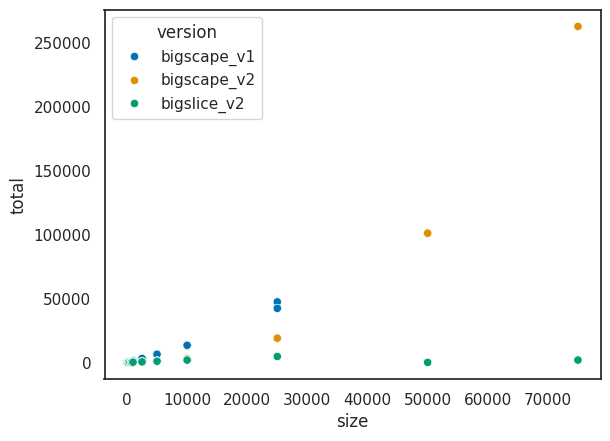

In [4]:

sns.scatterplot(totals, x="size", y="total", hue="version", palette=COLOR_MAP)

Text(0.5, 1.0, 'Runtime for sample sizes <= 10000')

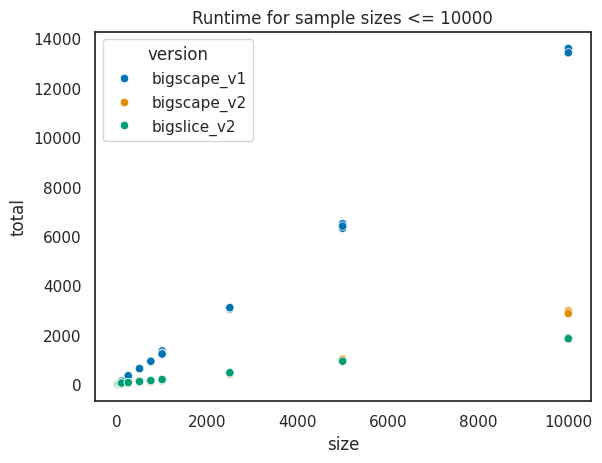

In [8]:
# points <= 10000
sns.scatterplot(totals[totals["size"] <= 10000], x="size", y="total", hue="version", palette=COLOR_MAP)
plt.title("Runtime for sample sizes <= 10000")

Text(0.5, 1.0, 'Proportional time spent on each step for v2')

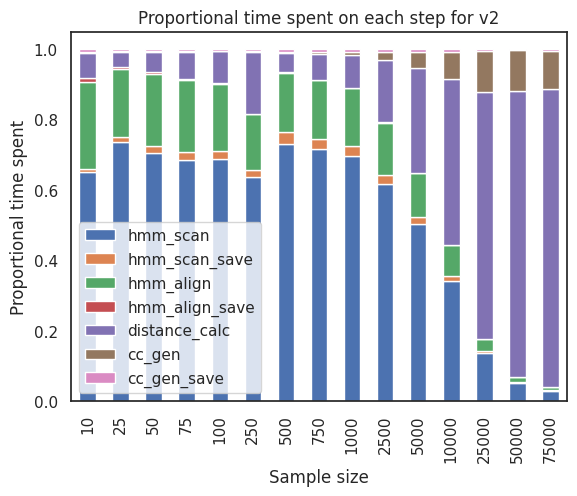

In [ ]:
prop_time_plot = bigscape_v2_avg_prop.plot(kind='bar', stacked=True)
prop_time_plot.set_xlabel("Sample size")
prop_time_plot.set_ylabel("Proportional time spent")
plt.title("Proportional time spent on each step for v2")

Text(0.5, 1.0, 'Proportional time spent on each step for v1')

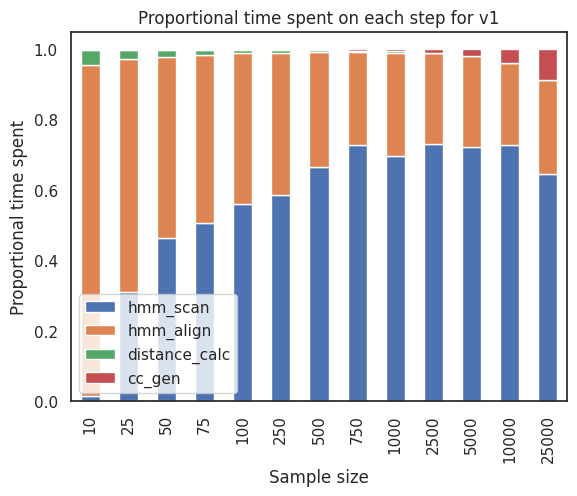

In [ ]:
prop_time_plot = bigscape_v1_avg_prop.plot(kind='bar', stacked=True)
prop_time_plot.set_xlabel("Sample size")
prop_time_plot.set_ylabel("Proportional time spent")
plt.title("Proportional time spent on each step for v1")